In [1]:
import seaborn as sns
from IPython.display import Image
import plotly
import matplotlib as plt
import pandas as pd
import numpy as np
import statsmodels as sm
import copy
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

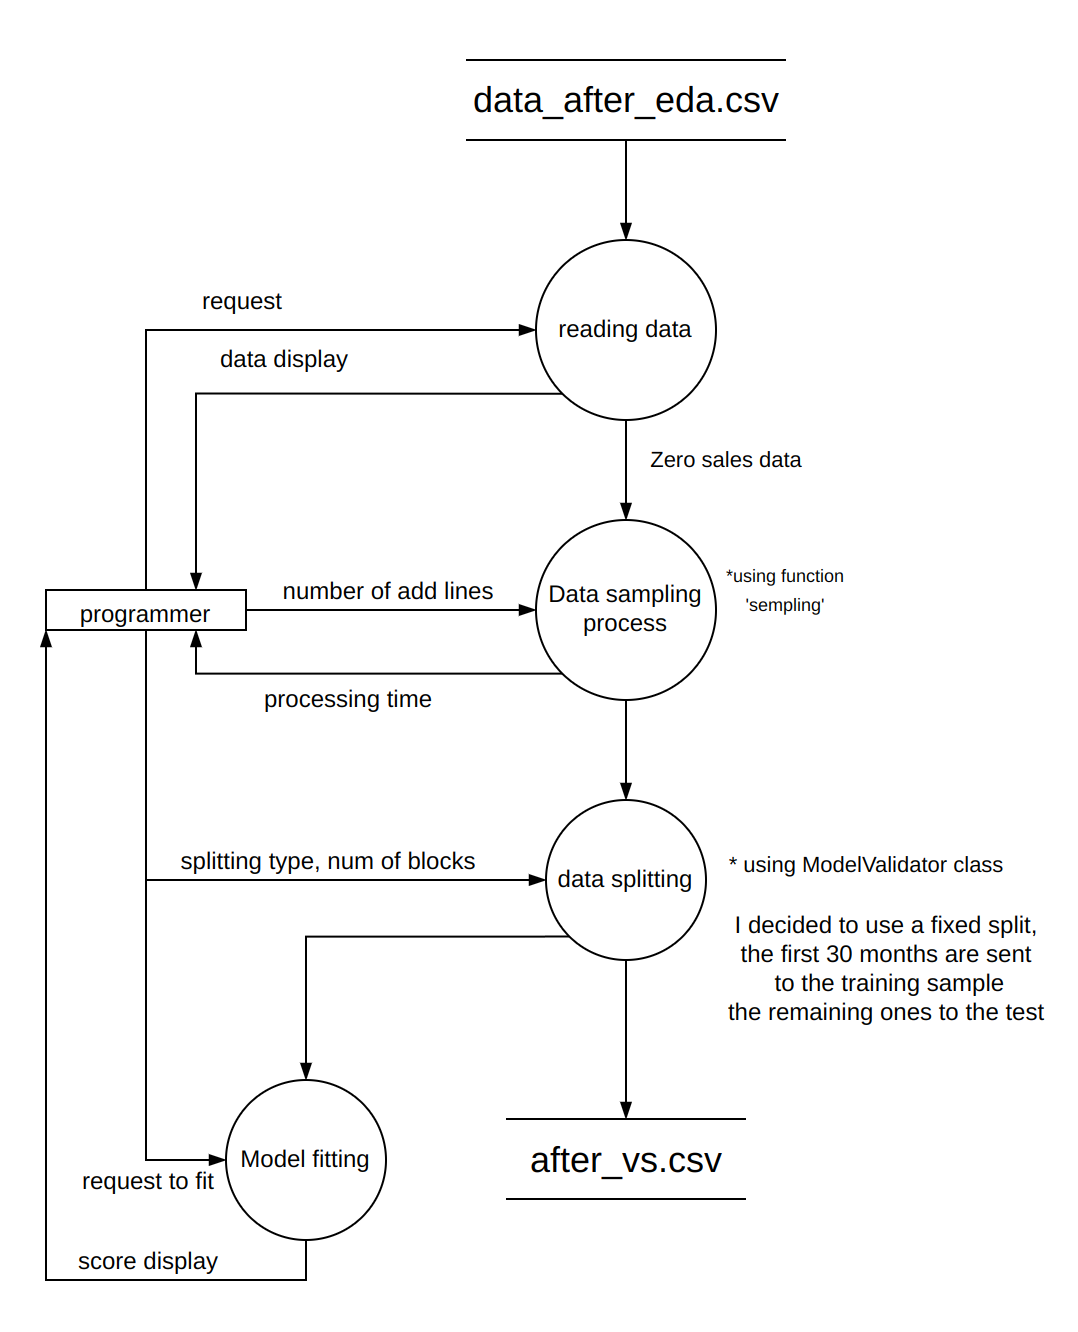

In [3]:
Image("scheme.png")

In [7]:
data = pd.read_csv('data_after_eda.csv')
sempling = pd.read_csv('sempled.csv') #after sempling(10%)

In [8]:
data = pd.concat([sempling,data[data.date_block_num>30]])

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ModelValidator:
    def __init__(self, data, target_name):
        self.model = None
        self.target_data = data[[target_name]]
        self.target_name = target_name
        self.data = data.drop(target_name, axis = 1)
        self.train_x = None
        self.train_y = None
        self.test_x = None
        self.test_y = None

    def get_model(self):
        return self.model
    
    def get_test(self):
        return self.test_x, self.test_y
    
    def get_train(self):
        return self.train_x, self.train_y

    def set_model(self, model_name):
        if model_name == 'lr':
            self.model = Ridge(alpha=1.3)
    
    def train_model(self):
        #for i in range(len(self.train_x)):
        #    self.model.fit(self.train_x[i], self.train_y[i])
        #    y_pred = self.model.predict(self.test_x[i])
        #    print(f'Batch : {i}\nMSE : {mean_squared_error(self.test_y[i], y_pred)}\nMAE : {mean_absolute_error(self.test_y[i], y_pred)}\n R2 : {r2_score(self.test_y[i], y_pred)}')
        self.model.fit(self.train_x, self.train_y)
        y_pred = self.model.predict(self.test_x)
        print(f'\nMSE : {mean_squared_error(self.test_y, y_pred)}\nMAE : {mean_absolute_error(self.test_y, y_pred)}\n R2 : {r2_score(self.test_y, y_pred)}')
        #print(f'Batch : {i}\nMSE : {mean_squared_error(self.test_y[i], y_pred)}\nMAE : {mean_absolute_error(self.test_y[i], y_pred)}\n R2 : {r2_score(self.test_y[i], y_pred)}')
        
    #will use FIRST months_to_train as training, other to dev
    def fixed_split(self, months_to_train):
        self.train_x = self.data[self.data.date_block_num <=months_to_train]
        self.train_y = self.target_data.head(self.train_x.shape[0])
        self.test_x = self.data[self.data.date_block_num >months_to_train]
        self.test_y = self.target_data.tail(self.test_x.shape[0])
    
    def expanding_windows(self, num_of_windows=33):
        splited_by_month_x = []
        splited_by_month_y = []
        
        data_blocks = self.data['date_block_num'].unique()
        
        for month in data_blocks:
            df = self.data[self.data['date_block_num'].isin([month])]
            indices = self.data.index[self.data['date_block_num'] == month]
            
            splited_by_month_x.append(df.values.tolist()) #3D array [DATA[MONTH[month, shop, id, ..., ...]]]
            splited_by_month_y.append(self.target_data.loc[indices].values.tolist())
        
        self.train_x = [splited_by_month_x[0]]
        self.train_y = [splited_by_month_y[0]]
        
        self.test_x = [splited_by_month_x[1]]
        self.test_y = [splited_by_month_y[1]]
        
        for i in range(1, num_of_windows):
            self.train_x.append(self.train_x[-1]+splited_by_month_x[i])
            self.train_y.append(self.train_y[-1]+splited_by_month_y[i])

            self.test_x.append(splited_by_month_x[i+1])
            self.test_y.append(splited_by_month_y[i+1])

In [34]:
import itertools
import random
import time

#worked version, just calculated from PC
def sempling(matrix, num_of_new_row):
    start_time = time.time()
    filtered_df = matrix[(matrix['shop_id'].isin(matrix['shop_id'].unique())) & (matrix['item_id'].isin(matrix['item_id'].unique()))]
    grouped = filtered_df.groupby(['shop_id','item_id'])['date_block_num'].min()
    all_date_block_nums = matrix.date_block_num.unique()
    for shop_id, item_id in itertools.product(matrix['shop_id'].unique(), matrix['item_id'].unique()):
        try: 
            first_date_block_num = grouped[shop_id, item_id] 
            block_num = np.random.choice(np.extract(all_date_block_nums > first_date_block_num, all_date_block_nums))
        except: continue
        if num_of_new_row == 0 :
            return matrix, grouped
        latest_row = filtered_df[(filtered_df['shop_id'] == shop_id) & (filtered_df['item_id'] == item_id) & (filtered_df['date_block_num'] < block_num)].sort_values(by='date_block_num', ascending=False).tail(1)
        new_row = {'date_block_num': block_num,
        'shop_id': shop_id,
        'item_id': item_id,
        'item_price': latest_row['item_price'].values[0],
        'item_cnt_day': 0.0,
        'is_train': latest_row['is_train'].values[0],
        'city_code': latest_row['city_code'].values[0],
        'shop_type_code': latest_row['shop_type_code'].values[0],
        'item_category_id': latest_row['item_category_id'].values[0],
        'platform_id': latest_row['platform_id'].values[0],
        'supercategory_id': latest_row['supercategory_id'].values[0],
        'item_name_group': latest_row['item_name_group'].values[0],
        'monthly_sales': 0.0}
        matrix = matrix.append(new_row, ignore_index=True)
        num_of_new_row = num_of_new_row - 1
        end_time = time.time()
        elapsed_time = end_time - start_time
    return matrix, grouped

start_time = time.time()
df_for_task = copy.deepcopy(b[b.date_block_num<=30])
final_df, ba = sempling(df_for_task, 350000)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time : ", elapsed_time)

Elapsed time for 100:  8.08073115348816


In [10]:
class Feature_extraction:
    def __init__(self, data):
        self.data = data
    
    def add_global_item_age(self):
        matrix = copy.deepcopy(self.data)    
        oldest_date_year_month = matrix.groupby('item_id')['date_block_num'].min()
        merged_df = pd.merge(matrix, oldest_date_year_month, on='item_id')
        merged_df = merged_df.rename(columns={'date_block_num_y': 'oldest_date'})
        merged_df['item_age'] = merged_df['date_block_num_x'] - merged_df['oldest_date']
        merged_df.drop(columns=['oldest_date'], inplace=True)
        self.data = copy.deepcopy(merged_df)
        self.data.rename(columns={'date_block_num_x':'date_block_num'}, inplace=True)
    
    def add_avg_sales(self, nan_values=0.0):
        df = copy.deepcopy(self.data)
        df['average_prev_sales'] = np.nan
        date_block_nums = df['date_block_num'].unique()

        for date_block_num in date_block_nums:
            if date_block_num == 0:
                prev_sales = df[(df['date_block_num'] == date_block_num)&(df['monthly_sales']!=0.0)]
                prev_sales = prev_sales.groupby('item_id')['item_cnt_day'].sum()/(date_block_num+1)
                df.loc[df['date_block_num'] == date_block_num,'average_prev_sales'] = nan_values
                continue
            prev_sales = df[(df['date_block_num'] < date_block_num)&(df['monthly_sales']!=0.0)]
            prev_sales = prev_sales.groupby('item_id')['item_cnt_day'].sum()/(date_block_num)
            df.loc[df['date_block_num'] == date_block_num,'average_prev_sales'] = df.loc[df['date_block_num'] == date_block_num,'item_id'].map(prev_sales)
        df.fillna(nan_values, inplace=True)
        self.data = copy.deepcopy(df)
    
    def add_shop_age(self):
        matrix = copy.deepcopy(self.data)
        min_date_block_num = matrix.groupby('shop_id')['date_block_num'].min()
        matrix = pd.merge(matrix, min_date_block_num, on='shop_id', how='left', suffixes=('', '_min'))
        matrix['shop_age_in_months'] = matrix['date_block_num'] - matrix['date_block_num_min']
        matrix.drop(columns=['date_block_num_min'], inplace=True)
        self.data = copy.deepcopy(matrix)
    
    def add_monthly_sales(self):
        matrix = copy.deepcopy(self.data)
        matrix['monthly_sales'] = matrix.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('sum')
        self.data = copy.deepcopy(matrix)
    
    def sort_data(self, column_name):
        self.data.sort_values(by=column_name, inplace=True)
    
    def get_data(self):
        return self.data

In [11]:
a = copy.deepcopy(data)
FE = Feature_extraction(a)
FE.sort_data('date_block_num')
FE.add_shop_age()
FE.add_avg_sales()
FE.add_global_item_age()
FE.sort_data('date_block_num')
df = FE.get_data()

In [12]:
df.to_csv('after_vs.csv')

In [10]:
test = df[df.is_train == False]
train = df[df['is_train']==True]
train.drop(columns=['date','item_cnt_day', 'is_train', 'ID'], inplace=True)
test.drop(columns=['date','item_cnt_day', 'is_train', 'monthly_sales'], inplace=True)

In [11]:
mv = ModelValidator(data=train, target_name='monthly_sales')
mv.fixed_split(30) #first 30 months to train, 3 last to dev, Kaggle submition as test
mv.set_model('lr') #to check data structure
mv.train_model()


MSE : 552.2408688431952
MAE : 11.711603731917434
 R2 : 0.0


In [13]:
model = mv.get_model()
test.sort_values(by=['ID'],inplace=True)
pred = model.predict(test.drop('ID', axis=1).values.tolist())

In [16]:
subm = test.drop(['Unnamed: 0.1', 'Unnamed: 0', 'date_block_num', 'shop_id','city_code', 'shop_type_code', 'item_category_id',
       'platform_id', 'supercategory_id', 'item_name_group',
       'date_block_num_diff', 'shop_age_in_months', 'average_prev_sales',
       'item_age', 'item_id', 'item_price'], axis=1)
subm['item_cnt_month'] = pred
subm.ID = subm.ID.astype('int32')
subm.item_cnt_month = subm.item_cnt_month.round()
subm.to_csv('subm_round.csv',index=False)

The resulting prediction gave me Score: 6.24153 on Kaggle

Of course this is definitely not a good score

but it shows that the data is processed correctly and the necessary structure is saved for Submission